In [18]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.linear_model
import ast
import matplotlib.pyplot as plt

In [2]:
interactions_test = pd.read_csv('interactions_test.csv')
interactions_train = pd.read_csv('interactions_train.csv')
interactions_validation = pd.read_csv('interactions_validation.csv')
PP_recipes = pd.read_csv('PP_recipes.csv').set_index('i').sort_index()
PP_users = pd.read_csv('PP_users.csv').set_index('u').sort_index()
RAW_interactions = pd.read_csv('RAW_interactions.csv')
RAW_recipes = pd.read_csv('RAW_recipes.csv')

In [3]:
recipe_review_counts = RAW_interactions.groupby('recipe_id')['rating'].count()
recipe_review_counts

recipe_id
38        4
39        1
40        9
41        2
43        1
         ..
537459    1
537485    1
537543    1
537671    1
537716    1
Name: rating, Length: 231637, dtype: int64

In [4]:
PP_recipes.dtypes

id                    int64
name_tokens          object
ingredient_tokens    object
steps_tokens         object
techniques           object
calorie_level         int64
ingredient_ids       object
dtype: object

In [ ]:
PP_recipes.merge(RAW_recipes, on='id', how='left')['n_steps']

,id,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids,n_reviewers,n_steps
i,,,,,,,,,
0,40893,"[40480, 1454, 16201, 2056, 955, 541, 11332, 82...","[[1424, 8876, 11007], [3484, 21453], [38966, 2...","[40480, 40482, 23667, 11007, 240, 21453, 240, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",0,"[3384, 7979, 2127, 3502, 3217, 1257, 2778, 500...",2,69
1,44394,"[40480, 34712, 22683, 11274, 5409, 29868, 40481]","[[5343, 535, 2044, 5409, 7087], [17869, 6020],...","[40480, 40482, 12172, 1281, 5409, 7087, 240, 6...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[912, 7557, 2499, 5382]",1,55
2,85009,"[40480, 12187, 13995, 571, 14719, 40481]","[[1061, 494, 813, 2141], [31843], [30645, 4785...","[40480, 40482, 2572, 19472, 31757, 512, 823, 4...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",2,"[4623, 6265, 1168, 6016, 3597, 3440, 7213, 169...",2,36
3,134728,"[40480, 27, 12, 263, 4017, 1494, 273, 14122, 4...","[[5867, 34056], [17918], [15022, 8361], [6953]...","[40480, 40482, 7087, 17918, 240, 6953, 488, 11...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[1304, 2683, 3217, 6270, 3532, 869, 7557, 3698...",7,135
4,200236,"[40480, 16212, 11880, 556, 19811, 12772, 22075...","[[16212, 1535], [6953], [1430, 1301, 11332], [...","[40480, 40482, 2525, 10906, 485, 29848, 40478,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",2,"[4130, 6270, 3486, 7557, 5010, 3203, 2683, 125...",4,176
...,...,...,...,...,...,...,...,...,...
178260,50804,"[40480, 5867, 3586, 17532, 14349, 29139, 40481]","[[589, 260, 4001, 17918], [6953], [15473, 1016...","[40480, 40482, 5867, 271, 715, 11868, 2525, 48...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",2,"[63, 6270, 335, 332, 4717, 2499, 6676, 4987, 6...",1,140
178261,492861,"[40480, 554, 13641, 2169, 40481]","[[1353], [2169], [1430, 857, 643, 1631], [1657...","[40480, 40482, 6927, 481, 11007, 271, 14259, 4...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7655, 1625, 3489, 7821]",2,194
178262,249924,"[40480, 7482, 8533, 9, 263, 1494, 273, 5867, 1...","[[1657, 5867], [24329, 26285], [6945, 978, 113...","[40480, 40482, 587, 616, 246, 850, 522, 867, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",2,"[7819, 1504, 1986, 3732, 7714]",5,159


In [ ]:
PP_recipes['n_reviewers'] = PP_recipes['id'].apply(lambda x: recipe_review_counts[x])
PP_recipes['name_tokens'] = PP_recipes['name_tokens'].apply(lambda x: ast.literal_eval(x))
PP_recipes['ingredient_tokens'] = PP_recipes['ingredient_tokens'].apply(lambda x: ast.literal_eval(x))
PP_recipes['steps_tokens'] = PP_recipes['steps_tokens'].apply(lambda x: ast.literal_eval(x))
PP_recipes['techniques'] = PP_recipes['techniques'].apply(lambda x: ast.literal_eval(x))
PP_recipes['ingredient_ids'] = PP_recipes['ingredient_ids'].apply(lambda x: ast.literal_eval(x))
PP_recipes['n_steps'] = PP_recipes.merge(RAW_recipes, on='id', how='left')['n_steps']

PP_recipes

,id,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids,n_reviewers,n_steps
i,,,,,,,,,
0,40893,"[40480, 1454, 16201, 2056, 955, 541, 11332, 82...","[[1424, 8876, 11007], [3484, 21453], [38966, 2...","[40480, 40482, 23667, 11007, 240, 21453, 240, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",0,"[3384, 7979, 2127, 3502, 3217, 1257, 2778, 500...",2,69
1,44394,"[40480, 34712, 22683, 11274, 5409, 29868, 40481]","[[5343, 535, 2044, 5409, 7087], [17869, 6020],...","[40480, 40482, 12172, 1281, 5409, 7087, 240, 6...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[912, 7557, 2499, 5382]",1,55
2,85009,"[40480, 12187, 13995, 571, 14719, 40481]","[[1061, 494, 813, 2141], [31843], [30645, 4785...","[40480, 40482, 2572, 19472, 31757, 512, 823, 4...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",2,"[4623, 6265, 1168, 6016, 3597, 3440, 7213, 169...",2,36
3,134728,"[40480, 27, 12, 263, 4017, 1494, 273, 14122, 4...","[[5867, 34056], [17918], [15022, 8361], [6953]...","[40480, 40482, 7087, 17918, 240, 6953, 488, 11...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[1304, 2683, 3217, 6270, 3532, 869, 7557, 3698...",7,135
4,200236,"[40480, 16212, 11880, 556, 19811, 12772, 22075...","[[16212, 1535], [6953], [1430, 1301, 11332], [...","[40480, 40482, 2525, 10906, 485, 29848, 40478,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",2,"[4130, 6270, 3486, 7557, 5010, 3203, 2683, 125...",4,176
...,...,...,...,...,...,...,...,...,...
178260,50804,"[40480, 5867, 3586, 17532, 14349, 29139, 40481]","[[589, 260, 4001, 17918], [6953], [15473, 1016...","[40480, 40482, 5867, 271, 715, 11868, 2525, 48...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",2,"[63, 6270, 335, 332, 4717, 2499, 6676, 4987, 6...",1,140
178261,492861,"[40480, 554, 13641, 2169, 40481]","[[1353], [2169], [1430, 857, 643, 1631], [1657...","[40480, 40482, 6927, 481, 11007, 271, 14259, 4...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7655, 1625, 3489, 7821]",2,194
178262,249924,"[40480, 7482, 8533, 9, 263, 1494, 273, 5867, 1...","[[1657, 5867], [24329, 26285], [6945, 978, 113...","[40480, 40482, 587, 616, 246, 850, 522, 867, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",2,"[7819, 1504, 1986, 3732, 7714]",5,159


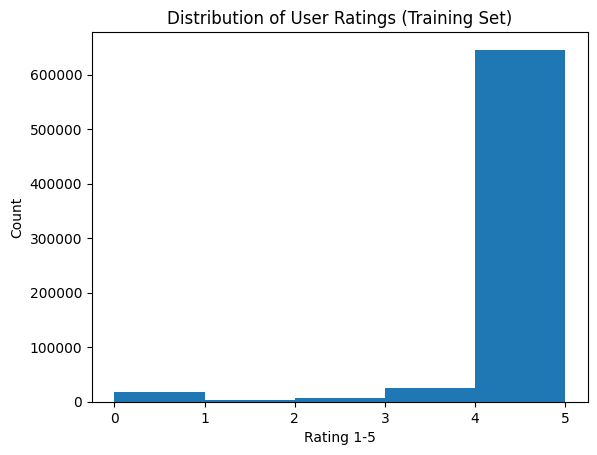

In [26]:
plt.hist(interactions_train['rating'], bins=5)
plt.xlabel('Rating 1-5')
plt.ylabel('Count')
plt.title('Distribution of User Ratings (Training Set)')
plt.show();

In [27]:
interactions_train.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


In [62]:
PP_recipes

,id,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids,n_reviewers,n_steps
i,,,,,,,,,
0,40893,"[40480, 1454, 16201, 2056, 955, 541, 11332, 82...","[[1424, 8876, 11007], [3484, 21453], [38966, 2...","[40480, 40482, 23667, 11007, 240, 21453, 240, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",0,"[3384, 7979, 2127, 3502, 3217, 1257, 2778, 500...",2,69
1,44394,"[40480, 34712, 22683, 11274, 5409, 29868, 40481]","[[5343, 535, 2044, 5409, 7087], [17869, 6020],...","[40480, 40482, 12172, 1281, 5409, 7087, 240, 6...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[912, 7557, 2499, 5382]",1,55
2,85009,"[40480, 12187, 13995, 571, 14719, 40481]","[[1061, 494, 813, 2141], [31843], [30645, 4785...","[40480, 40482, 2572, 19472, 31757, 512, 823, 4...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",2,"[4623, 6265, 1168, 6016, 3597, 3440, 7213, 169...",2,36
3,134728,"[40480, 27, 12, 263, 4017, 1494, 273, 14122, 4...","[[5867, 34056], [17918], [15022, 8361], [6953]...","[40480, 40482, 7087, 17918, 240, 6953, 488, 11...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[1304, 2683, 3217, 6270, 3532, 869, 7557, 3698...",7,135
4,200236,"[40480, 16212, 11880, 556, 19811, 12772, 22075...","[[16212, 1535], [6953], [1430, 1301, 11332], [...","[40480, 40482, 2525, 10906, 485, 29848, 40478,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",2,"[4130, 6270, 3486, 7557, 5010, 3203, 2683, 125...",4,176
...,...,...,...,...,...,...,...,...,...
178260,50804,"[40480, 5867, 3586, 17532, 14349, 29139, 40481]","[[589, 260, 4001, 17918], [6953], [15473, 1016...","[40480, 40482, 5867, 271, 715, 11868, 2525, 48...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",2,"[63, 6270, 335, 332, 4717, 2499, 6676, 4987, 6...",1,140
178261,492861,"[40480, 554, 13641, 2169, 40481]","[[1353], [2169], [1430, 857, 643, 1631], [1657...","[40480, 40482, 6927, 481, 11007, 271, 14259, 4...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7655, 1625, 3489, 7821]",2,194
178262,249924,"[40480, 7482, 8533, 9, 263, 1494, 273, 5867, 1...","[[1657, 5867], [24329, 26285], [6945, 978, 113...","[40480, 40482, 587, 616, 246, 850, 522, 867, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",2,"[7819, 1504, 1986, 3732, 7714]",5,159


In [70]:
merged = interactions_train.merge(PP_recipes, left_on='recipe_id', right_on='id', how='left')
avg_ratings_per_recipe = merged.groupby('recipe_id')['rating'].mean()

Text(0, 0.5, 'Average Rating of Recipe')

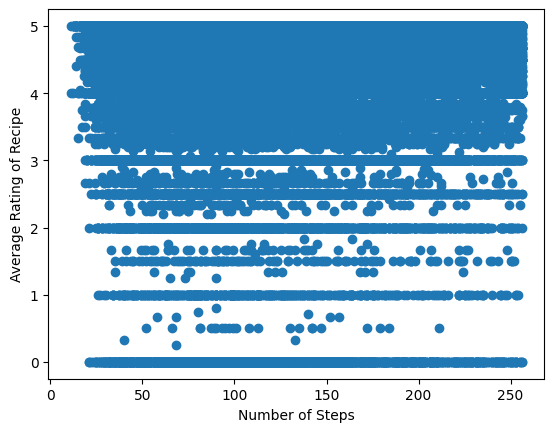

In [71]:
steps_per_recipe = merged.groupby('recipe_id')['n_steps'].first()

plt.scatter(steps_per_recipe, avg_ratings_per_recipe)
plt.xlabel('Number of Steps')
plt.ylabel('Average Rating of Recipe')

In [75]:
len(PP_recipes['steps_tokens'][0])

69

In [ ]:
calorie_level_per_recipe = merged.groupby('recipe_id')['calorie_level'].first()

plt.scatter(steps_per_recipe, avg_ratings_per_recipe)
plt.xlabel('Number of Steps')
plt.ylabel('')

In [60]:
PP_recipes.sort_values('id').set_index('id')

,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids,n_reviewers,n_steps
id,,,,,,,,
38,"[40480, 954, 4739, 6449, 1674, 4787, 10601, 40...","[[12698, 11125], [4465, 29487, 6444], [15000, ...","[40480, 40482, 8263, 280, 7420, 11125, 556, 64...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[648, 3355, 7501, 4253]",4,120
40,"[40480, 1432, 17746, 40481]","[[6444], [30295, 240, 17, 686, 498], [3137, 13...","[40480, 40482, 666, 246, 277, 660, 2212, 7932,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[6906, 4303, 2919, 2832, 3829, 1567]",9,104
45,"[40480, 6796, 5940, 7056, 556, 32669, 5776, 32...","[[6444], [7424, 745], [8441], [8441, 15953], [...","[40480, 40482, 729, 2525, 10906, 485, 43, 2885...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[6906, 4574, 2499, 2509, 2683, 6270, 869, 3324...",3,144
46,"[40480, 246, 31704, 30710, 25199, 40481]","[[6878, 26285], [477, 869, 27, 14861], [548, 2...","[40480, 40482, 8654, 481, 30710, 500, 1667, 29...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,[6082],2,80
49,"[40480, 5867, 6285, 518, 892, 489, 5385, 40481]","[[3137, 19104], [8780], [31801, 918, 15509, 58...","[40480, 40482, 5539, 19104, 500, 280, 3, 21, 3...","[1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",2,"[2847, 840, 1254, 2683, 4593, 1257, 6270, 4836...",20,245
...,...,...,...,...,...,...,...,...
537175,"[40480, 9194, 3779, 28058, 1431, 523, 5825, 40...","[[2832, 1431, 523], [2107, 1353], [4017], [313...","[40480, 40482, 729, 2525, 481, 10906, 485, 266...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[7956, 7650, 3723, 6283, 6270, 2499, 63]",1,197
537319,"[40480, 18376, 16361, 30084, 40481]","[[4017], [2507, 6444], [15000, 18347], [18376,...","[40480, 40482, 729, 2525, 704, 10906, 485, 43,...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,"[3723, 800, 7470, 5764, 7557, 4998, 5298, 3311]",1,123
537458,"[40480, 15022, 488, 16084, 17921, 10837, 40481]","[[8450, 25489, 2883, 10837], [4914, 6821], [87...","[40480, 40482, 1082, 10837, 488, 1353, 485, 24...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[8012, 1910, 840, 6654, 3670, 2776, 2856, 3203...",1,103


In [44]:
PP_recipes.loc[[1,2]]

,id,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids,n_reviewers,n_steps
i,,,,,,,,,
1,44394,"[40480, 34712, 22683, 11274, 5409, 29868, 40481]","[[5343, 535, 2044, 5409, 7087], [17869, 6020],...","[40480, 40482, 12172, 1281, 5409, 7087, 240, 6...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[912, 7557, 2499, 5382]",1,55
2,85009,"[40480, 12187, 13995, 571, 14719, 40481]","[[1061, 494, 813, 2141], [31843], [30645, 4785...","[40480, 40482, 2572, 19472, 31757, 512, 823, 4...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",2,"[4623, 6265, 1168, 6016, 3597, 3440, 7213, 169...",2,36


In [21]:
interactions_train['rating'].value_counts()

rating
5.0    518568
4.0    127402
3.0     25781
0.0     16957
2.0      6852
1.0      3341
Name: count, dtype: int64

In [6]:
PP_users['techniques'] = PP_users['techniques'].apply(lambda x: ast.literal_eval(x))
PP_users['items'] = PP_users['items'].apply(lambda x: ast.literal_eval(x))
PP_users['ratings'] = PP_users['ratings'].apply(lambda x: ast.literal_eval(x))

PP_users

,techniques,items,n_items,ratings,n_ratings
u,,,,,
0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27
3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376
...,...,...,...,...,...
25071,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[144172, 154054]",2,"[5.0, 5.0]",2
25072,"[1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[162436, 148228]",2,"[5.0, 5.0]",2
25073,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[162681, 172034]",2,"[5.0, 5.0]",2


In [7]:
PP_recipes.dtypes

id                    int64
name_tokens          object
ingredient_tokens    object
steps_tokens         object
techniques           object
calorie_level         int64
ingredient_ids       object
n_reviewers           int64
n_steps               int64
dtype: object

In [8]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

def MSE(predictions, y):
    diffs = [(a-b)**2 for (a,b) in zip(predictions, y)]
    return sum(diffs)/len(diffs)

def euclidean_distance(arr1, arr2):
    return np.sqrt(sum((arr1 - arr2)**2))

def normalize(arr):
    min = np.min(arr)
    max = np.max(arr)

    return (arr - min) / (max - min)

In [9]:
train_X = interactions_train.drop(columns=['rating'])
train_y = interactions_train['rating']
validation_X = interactions_validation.drop(columns=['rating'])
validation_y = interactions_validation['rating']
test_X = interactions_test.drop(columns=['rating'])
test_y = interactions_test['rating']

In [10]:
PP_recipes

,id,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids,n_reviewers,n_steps
i,,,,,,,,,
0,40893,"[40480, 1454, 16201, 2056, 955, 541, 11332, 82...","[[1424, 8876, 11007], [3484, 21453], [38966, 2...","[40480, 40482, 23667, 11007, 240, 21453, 240, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",0,"[3384, 7979, 2127, 3502, 3217, 1257, 2778, 500...",2,69
1,44394,"[40480, 34712, 22683, 11274, 5409, 29868, 40481]","[[5343, 535, 2044, 5409, 7087], [17869, 6020],...","[40480, 40482, 12172, 1281, 5409, 7087, 240, 6...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[912, 7557, 2499, 5382]",1,55
2,85009,"[40480, 12187, 13995, 571, 14719, 40481]","[[1061, 494, 813, 2141], [31843], [30645, 4785...","[40480, 40482, 2572, 19472, 31757, 512, 823, 4...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",2,"[4623, 6265, 1168, 6016, 3597, 3440, 7213, 169...",2,36
3,134728,"[40480, 27, 12, 263, 4017, 1494, 273, 14122, 4...","[[5867, 34056], [17918], [15022, 8361], [6953]...","[40480, 40482, 7087, 17918, 240, 6953, 488, 11...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[1304, 2683, 3217, 6270, 3532, 869, 7557, 3698...",7,135
4,200236,"[40480, 16212, 11880, 556, 19811, 12772, 22075...","[[16212, 1535], [6953], [1430, 1301, 11332], [...","[40480, 40482, 2525, 10906, 485, 29848, 40478,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",2,"[4130, 6270, 3486, 7557, 5010, 3203, 2683, 125...",4,176
...,...,...,...,...,...,...,...,...,...
178260,50804,"[40480, 5867, 3586, 17532, 14349, 29139, 40481]","[[589, 260, 4001, 17918], [6953], [15473, 1016...","[40480, 40482, 5867, 271, 715, 11868, 2525, 48...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",2,"[63, 6270, 335, 332, 4717, 2499, 6676, 4987, 6...",1,140
178261,492861,"[40480, 554, 13641, 2169, 40481]","[[1353], [2169], [1430, 857, 643, 1631], [1657...","[40480, 40482, 6927, 481, 11007, 271, 14259, 4...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7655, 1625, 3489, 7821]",2,194
178262,249924,"[40480, 7482, 8533, 9, 263, 1494, 273, 5867, 1...","[[1657, 5867], [24329, 26285], [6945, 978, 113...","[40480, 40482, 587, 616, 246, 850, 522, 867, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",2,"[7819, 1504, 1986, 3732, 7714]",5,159


In [11]:
PP_users

,techniques,items,n_items,ratings,n_ratings
u,,,,,
0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27
3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376
...,...,...,...,...,...
25071,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[144172, 154054]",2,"[5.0, 5.0]",2
25072,"[1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[162436, 148228]",2,"[5.0, 5.0]",2
25073,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[162681, 172034]",2,"[5.0, 5.0]",2


In [12]:
# Baseline 1: Always Predict Global Average

global_average = interactions_train['rating'].mean()
print('Mean Squared Error for Baseline 1 (Always Predict Global Average):', MSE([global_average] * test_y.shape[0], test_y))

# Baseline 2: Regresssion With Two Predictors

baseline_train_X_features = [[PP_recipes.iloc[i]['calorie_level'], PP_users.iloc[u]['n_items']] for u, i in train_X[['u', 'i']].to_numpy()]
baseline_test_X_features = [[PP_recipes.iloc[i]['calorie_level'], PP_users.iloc[u]['n_items']] for u, i in test_X[['u', 'i']].to_numpy()]

baseline_model = sklearn.linear_model.LinearRegression()
baseline_model.fit(baseline_train_X_features, train_y)
baseline_model_preds = baseline_model.predict(baseline_test_X_features)
print('Mean Squared Error for Baseline 2 (Regrission With Two Predictors):', MSE(baseline_model_preds, test_y))

Mean Squared Error for Baseline 1 (Always Predict Global Average): 1.921769558034767
Mean Squared Error for Baseline 2 (Regrission With Two Predictors): 1.889391224000372


In [13]:
interactions_test

,user_id,recipe_id,date,rating,u,i
0,8937,44551,2005-12-23,4.0,2,173538
1,56680,126118,2006-10-07,4.0,16,177847
2,349752,219596,2008-04-12,0.0,26,89896
3,628951,82783,2007-11-13,2.0,45,172637
4,92816,435013,2013-07-31,3.0,52,177935
...,...,...,...,...,...,...
12450,101053,179011,2009-01-03,5.0,25054,130258
12451,252205,81398,2005-12-26,2.0,25055,152255
12452,624305,142984,2011-01-15,1.0,25057,139864
12453,173575,104842,2004-12-18,3.0,25059,140646


In [14]:
def get_familiarity(datum, col):
    user = datum['u']
    recipe = datum['i']
    recipe_ingredients = set(PP_recipes.iloc[recipe][col])

    user_known_recipes = PP_users.iloc[user]['items']
    jaccard_sims = []

    for i in user_known_recipes:
        known_recipe_ingredients = set(PP_recipes.iloc[i][col])
        jaccard_sims.append(Jaccard(recipe_ingredients, known_recipe_ingredients))

    return np.mean(jaccard_sims)

In [15]:
def feature(datum):
    user = datum['u']
    recipe = datum['i']

    user_num_reviews = PP_users.iloc[user]['n_ratings']

    recipe_num_reviewers = PP_recipes.iloc[recipe]['n_reviewers']

    recipe_calorie_level = PP_recipes.iloc[recipe]['calorie_level']

    recipe_num_steps = PP_recipes.iloc[recipe]['n_steps']

    # mean of jaccards might not be the best way to evaluate familiarity
    # maybe modify to address people with low review counts?
    # modify to reduce the impact of very common ingredients like salt?
    ingredient_familiarity = get_familiarity(datum, 'ingredient_ids')

    steps_familiarity = get_familiarity(datum, 'steps_tokens')

    technique_familiarity = (np.array(PP_users.iloc[user]['techniques']) * np.array(PP_recipes.iloc[recipe]['techniques'])).sum() / np.array(PP_recipes.iloc[recipe]['techniques']).sum()

    return [user_num_reviews, recipe_num_reviewers, recipe_calorie_level, recipe_num_steps, ingredient_familiarity, steps_familiarity, technique_familiarity]
